In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Fri Jan 12 17:20:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   24C    P8    14W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.latent_layer.sampling_uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.0202789306640625
encoder.convs 5.989013671875
encoder.linear 0.0312652587890625
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.12-8/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 37628
-rw-rw-r-- 1 scpark scpark   205988  1월 12 17:20 events.out.tfevents.1705047506.GPUSVR01
-rw-rw-r-- 1 scpark scpark 38023101  1월 12 17:18 save_0
-rw-rw-r-- 1 scpark scpark   297427  1월 12 17:18 events.out.tfevents.1705047330.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


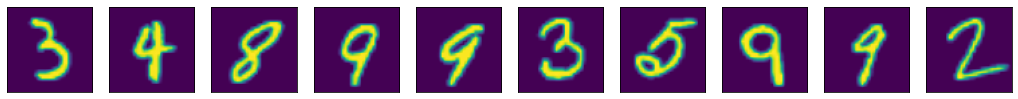

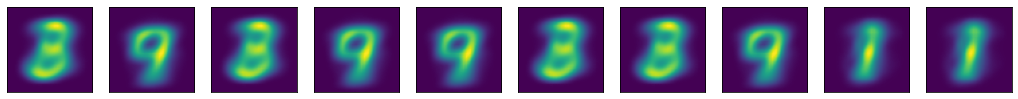

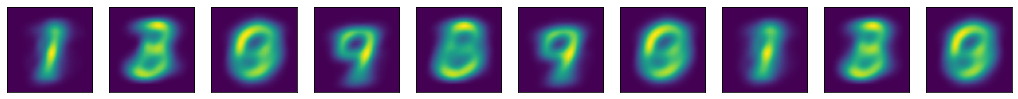

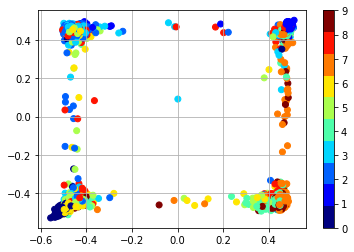

118001
lse_loss -3.2274880409240723
recon_loss 0.21013693511486053
118002
lse_loss -3.221888303756714
recon_loss 0.2050246298313141
118003
lse_loss -3.2223734855651855
recon_loss 0.20769727230072021
118004
lse_loss -3.212827682495117
recon_loss 0.2028023600578308
118005
lse_loss -3.2195966243743896
recon_loss 0.20306943356990814
118006
lse_loss -3.218430757522583
recon_loss 0.20701128244400024
118007
lse_loss -3.2276721000671387
recon_loss 0.1987525224685669
118008
lse_loss -3.211456298828125
recon_loss 0.2015278935432434
118009
lse_loss -3.2092347145080566
recon_loss 0.20861896872520447
118010
lse_loss -3.2012157440185547
recon_loss 0.204122394323349
118011
lse_loss -3.2179417610168457
recon_loss 0.1983134001493454
118012
lse_loss -3.2145557403564453
recon_loss 0.2152363359928131
118013
lse_loss -3.203310251235962
recon_loss 0.20333698391914368
118014
lse_loss -3.218980073928833
recon_loss 0.20841269195079803
118015
lse_loss -3.238030433654785
recon_loss 0.20997467637062073
118016
lse

118127
lse_loss -3.2186012268066406
recon_loss 0.19712361693382263
118128
lse_loss -3.1960606575012207
recon_loss 0.20168936252593994
118129
lse_loss -3.231985569000244
recon_loss 0.2047995924949646
118130
lse_loss -3.205375909805298
recon_loss 0.21090948581695557
118131
lse_loss -3.22733998298645
recon_loss 0.20876877009868622
118132
lse_loss -3.193563461303711
recon_loss 0.20734159648418427
118133
lse_loss -3.2083520889282227
recon_loss 0.21310874819755554
118134
lse_loss -3.196106195449829
recon_loss 0.20732614398002625
118135
lse_loss -3.2070553302764893
recon_loss 0.20971208810806274
118136
lse_loss -3.2299551963806152
recon_loss 0.20712026953697205
118137
lse_loss -3.227573871612549
recon_loss 0.19876468181610107
118138
lse_loss -3.2321619987487793
recon_loss 0.20200657844543457
118139
lse_loss -3.2223615646362305
recon_loss 0.20751707255840302
118140
lse_loss -3.192075729370117
recon_loss 0.20099672675132751
118141
lse_loss -3.2087290287017822
recon_loss 0.20098482072353363
1181

lse_loss -3.189811944961548
recon_loss 0.21349021792411804
118255
lse_loss -3.2356035709381104
recon_loss 0.20821166038513184
118256
lse_loss -3.226292133331299
recon_loss 0.21210166811943054
118257
lse_loss -3.1921255588531494
recon_loss 0.20647522807121277
118258
lse_loss -3.2248475551605225
recon_loss 0.21157386898994446
118259
lse_loss -3.202599048614502
recon_loss 0.2037167251110077
118260
lse_loss -3.209538698196411
recon_loss 0.21083447337150574
118261
lse_loss -3.2101950645446777
recon_loss 0.21155457198619843
118262
lse_loss -3.231135845184326
recon_loss 0.21608394384384155
118263
lse_loss -3.223306894302368
recon_loss 0.20866601169109344
118264
lse_loss -3.2131922245025635
recon_loss 0.20578686892986298
118265
lse_loss -3.207820177078247
recon_loss 0.20691291987895966
118266
lse_loss -3.2066025733947754
recon_loss 0.21221540868282318
118267
lse_loss -3.20342755317688
recon_loss 0.2008478045463562
118268
lse_loss -3.209789752960205
recon_loss 0.20576211810112
118269
lse_loss -

118383
lse_loss -3.208522081375122
recon_loss 0.19949540495872498
118384
lse_loss -3.2007741928100586
recon_loss 0.20050063729286194
118385
lse_loss -3.212886333465576
recon_loss 0.2057134211063385
118386
lse_loss -3.218967914581299
recon_loss 0.19728325307369232
118387
lse_loss -3.1972320079803467
recon_loss 0.21241772174835205


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=4e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-2)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z_mean'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        